# Recurrent Neural Netowrks with LSTM/GRU cells

Read csv into pandas dataframe

In [ ]:
import pandas as pd

df = pd.read_csv('imdb-reviews.csv', sep='\t')

Create functions used for data cleaning and apply them to our dataframe.

The function data_preprocessing() can be used for any dataframe we want to preprocess/transform later.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords

def rate_to_pos_neg(row):
  if row['rating'] <= 4:
    return 0
  elif row['rating'] >= 7:
    return 1

def data_preprocessing(df):

  stop = set(stopwords.words('english'))

  df['reviews_edited'] = df['review'].str.lower() # lowercase

  # lemmatize text to group together the different inflected forms of a word so they can be analyzed as a single item
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = nltk.stem.WordNetLemmatizer()

  def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

  df['reviews_edited'] = df['reviews_edited'].apply(lemmatize_text)

  df['reviews_edited'] = df['reviews_edited'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # remove stopwords
  df['reviews_edited'] = df['reviews_edited'].str.replace("n\'t", " not", regex=True) # replace n't with not
  df['reviews_edited'] = df['reviews_edited'].str.replace(r'<br />', ' ', regex=True) # remove html break lines
  df["reviews_edited"] = df['reviews_edited'].str.replace('[^\w\s]','', regex=True) # remove punctuation

  df['target'] = df.apply(rate_to_pos_neg, axis=1)

  return df

df = data_preprocessing(df)

df

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


,url,rating,review,reviews_edited,target
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...,thought wa quiet good movie wa fun watch it li...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...,wagon master unique film amongst john fords wo...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...,film ha near perfect film john ford made film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...,gave 4 star ha lot interesting theme many alre...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...,movie really genuine random really hard find m...,1
...,...,...,...,...,...
45003,http://www.imdb.com/title/tt0449000/usercomments,1.0,I don't even know where to begin...<br /><br /...,even know begin its worth typing review quote...,0
45004,http://www.imdb.com/title/tt0109382/usercomments,1.0,One of the worst movies I saw in the 90s. I'd ...,one worst movie saw 90s id often use benchmark...,0
45005,http://www.imdb.com/title/tt0375560/usercomments,1.0,Baldwin has really stooped low to make such mo...,baldwin ha really stooped low make movies scri...,0
45006,http://www.imdb.com/title/tt0165107/usercomments,1.0,If you liked watching Mel Gibson in Million Do...,liked watching mel gibson million dollar hotel...,0


Create x, y datasets based on the features we need.

In [ ]:
df = df[['reviews_edited', 'target']]
x = df[['reviews_edited']]
y = df[['target']]
df

,reviews_edited,target
0,thought wa quiet good movie wa fun watch it li...,1
1,wagon master unique film amongst john fords wo...,1
2,film ha near perfect film john ford made film ...,1
3,gave 4 star ha lot interesting theme many alre...,0
4,movie really genuine random really hard find m...,1
...,...,...
45003,even know begin its worth typing review quote...,0
45004,one worst movie saw 90s id often use benchmark...,0
45005,baldwin ha really stooped low make movies scri...,0
45006,liked watching mel gibson million dollar hotel...,0


Split into train, valitation and test datasets with 80%, 16% and 4% proportion of the whole dataset respectively.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_val_test, y_train, y_val_test = train_test_split(x, np.ravel(y), test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, np.ravel(y_val_test), test_size=0.2, random_state=42)

Create a custom Dataset class which inherits the Dataset class of torch.utils.data and creates a dataset using glove embeddings from Stanford using torchtext. For each review, we get the index vector of each word and add it in a list. The result when regarding a set of reviews, is a list of these lists.

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import itertools
import torchtext
!pip install optuna
import optuna

device = torch.device("cuda")

vector_length = 300
glove = torchtext.vocab.GloVe(name="6B", dim = vector_length, max_vectors = 10000)

class CustomDataset(Dataset):

  def __init__(self, x_dataset, y_dataset):

    self.labels = y_dataset
    self.array = []

    for review in x_dataset.reviews_edited:
      # string to index from word2vec embeddings
      self.array.append(np.array([glove.stoi[word] for word in review.split() if word in glove.stoi]))

  def __getitem__(self, idx):
    return torch.tensor(self.array[idx]).to(device), torch.tensor(self.labels[idx]).to(device)

  def len(self):
    return len(self.labels)

  def __len__(self):
    return len(self.labels)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                               
100%|█████████▉| 9999/10000 [00:01<00:00, 9574.86it/s]


Create train, validation and test datasets using the class we previously defined and the train, validation and test data we previously splitted. Also print the size of its dataset.

In [ ]:
train_dataset = CustomDataset(x_train, y_train)
validation_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

print("Train size is: ", train_dataset.len())
print("Validation size is: ", validation_dataset.len())
print("Test size is: ", test_dataset.len())

Train size is:  36006
Validation size is:  7201
Test size is:  1801


Define the dimensions for our recurrent neural networks.

Batch size needs to be big enough so that we avoid noise, but small enough to allow the model to be trained fast, while using less memory. This number is usually near the square root of the dataset size (for our case, the train dataset size is ca. 36000), so we define it as 256 here.

Other hyperparameters are explored later using Optuna, an automatic hyperparameter optimization software framework.

In [ ]:
input_size = vector_length
batch_size = 256
num_epochs = 12
num_classes = 2

We define two neural network architectures, one using LSTM class from Pytorch and one using GRU class. Both archtiectures use the corresponding Pytorch class, which returns `h_n` of shape `D ∗ num_layers, N, H_out`. This output is then given as input to a fully connected linear layer in an appropriate way.

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.nn.functional as F

# implements attention using softmax((QK^T)/sqrt(dk))*V, as described in the tutorial given by instructors in piazza
# input: queries, keys, values, hidden_size
def attention(q, k, v, hidden_size):
  attention = F.softmax(torch.bmm(q.unsqueeze(1), k.transpose(1,2))/np.sqrt(len(k)), -1)
  return torch.bmm(attention, v).squeeze(1)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, attention = False):

        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.attention = attention
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional = True, batch_first = True, dropout = 0.5)
        self.fc = nn.Linear(hidden_size*2, num_classes)

        self.fc_attention = nn.Linear(hidden_size*2, hidden_size*2)

        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.embedding.weight.requires_grad = True

    def forward(self, x, lens):

        x = self.embedding(x)
        x = pack_padded_sequence(x, lens, batch_first = True, enforce_sorted = False)
        self.rnn.flatten_parameters()

        out, (h_n, c_n) = self.rnn(x) # LSTM also returns c_n, except from h_n

        out, _ = pad_packed_sequence(out, batch_first = True)

        if self.attention:
          attention_input = attention(torch.cat((h_n[-1,:,:], h_n[-2,:,:]), dim = 1), out, out, self.hidden_size)
          return self.fc(self.fc_attention(attention_input))

        out = self.fc(torch.cat((h_n[-1,:,:], h_n[-2,:,:]), dim = 1))

        return out

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, attention = False):

        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.attention = attention
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, bidirectional = True, batch_first = True, dropout = 0.5)
        self.fc = nn.Linear(hidden_size*2, num_classes)

        self.fc_attention = nn.Linear(hidden_size*2, hidden_size*2)

        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.embedding.weight.requires_grad = True

    def forward(self, x, lens):

        x = self.embedding(x)
        x = pack_padded_sequence(x, lens, batch_first = True, enforce_sorted = False)
        self.rnn.flatten_parameters()

        out, h_n = self.rnn(x)

        out, _ = pad_packed_sequence(out, batch_first = True)

        if self.attention:
          attention_input = attention(torch.cat((h_n[-1,:,:], h_n[-2,:,:]), dim = 1), out, out, self.hidden_size)
          return self.fc(self.fc_attention(attention_input))

        out = self.fc(torch.cat((h_n[-1,:,:], h_n[-2,:,:]), dim = 1))

        return out

Collate function used for the dataloaders in the next step. When iterating through each dataloader, we need to fet the padded sequence, the length of the x batch data and the y data of the same batch.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate(batch):
    (x_batch, y_batch) = zip(*batch)
    lengths = [len(x) for x in x_batch]
    y_batch_stacked = torch.stack(list(y_batch))
    return (pad_sequence(x_batch, batch_first = True, padding_value = 0), lengths), y_batch_stacked.to(device)

Create dataloaders for each set of data to use for the training, validation and evalueation of the models, later.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size,
                                               shuffle = True, collate_fn = collate)

In [ ]:
validation_dataloader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = batch_size,
                                                    shuffle = True, collate_fn = collate)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size,
                                              shuffle = True, collate_fn = collate)

In order to tune the hyperparameters of each model, we will use Optuna, an automatic hyperparameter optimization software framework. We are going to tune learning rate, the hidden size of each layer and the number of hidden layers of each neural network architecture. For each parameter we provide a range of values or specific categorical values that we think are appropriate for our problem and models.

Adam optimizer and the cross-entropy loss function are used, as stipulated for the exercise.

The metric used to examine the best hyperparameters is the maximization of F1-score, which provides a combination of precision and recall metrics.

In [ ]:
def objective_lstm(trial):

     params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
              'hidden_size': trial.suggest_categorical("hidden_size", [128, 256]),
              'hidden_layers': trial.suggest_categorical("hidden_layers", [2, 3])
              }
    
     model = LSTM(input_size, params['hidden_size'], params['hidden_layers'], num_classes).to(device)

     criterion = nn.CrossEntropyLoss()
     optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay=0.008)
    
     all_train_labels, all_train_predictions, all_val_labels, all_val_predictions = train_model(model,
                            num_epochs, train_dataloader, validation_dataloader, criterion, optimizer)

     return f1_score(all_val_labels, all_val_predictions)

def objective_gru(trial):

     params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
              'hidden_size': trial.suggest_categorical("hidden_size", [128, 256]),
              'hidden_layers': trial.suggest_categorical("hidden_layers", [2, 3])
              }
    
     model = GRU(input_size, params['hidden_size'], params['hidden_layers'], num_classes).to(device)

     criterion = nn.CrossEntropyLoss()
     optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay=0.006)
    
     all_train_labels, all_train_predictions, all_val_labels, all_val_predictions = train_model(model,
                            num_epochs, train_dataloader, validation_dataloader, criterion, optimizer)

     return f1_score(all_val_labels, all_val_predictions)

The following function helps us train each of the previous defined models, export statistics about their scores and plot them.

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, plots = False):
  train_loss = []
  val_loss = []
  train_accuracy = []
  val_accuracy = []
  train_precision = []
  val_precision = []
  train_recall = []
  val_recall = []
  train_f1 = []
  val_f1 = []
  for epoch in range(num_epochs):
    for i, ((reviews, reviews_len), labels) in enumerate(train_dataloader):

      # Forward pass
      outputs = model(reviews, reviews_len)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # we may want to print loss after the end each epoch
    # print(loss.item())

    # no gradients needed
    with torch.no_grad():

      # checking fit for the training set itself

      all_train_labels = np.array([])
      all_train_predictions = np.array([])
      y_train = np.array([])

      for i, ((reviews, reviews_len), labels) in enumerate(train_dataloader):
        y_train = np.append(y_train, labels.cpu().numpy())
        all_train_labels = np.append(all_train_labels, labels.cpu().numpy())
        outputs = model(reviews, reviews_len)
        
        _, predictions = torch.max(outputs, 1)
        all_train_predictions = np.append(all_train_predictions, predictions.cpu().numpy())
        loss = criterion(outputs, labels)

      train_loss.append(loss.item())
      train_accuracy.append(accuracy_score(all_train_labels, all_train_predictions))
      train_precision.append(precision_score(all_train_labels, all_train_predictions))
      train_recall.append(recall_score(all_train_labels, all_train_predictions))
      train_f1.append(f1_score(all_train_labels, all_train_predictions))

      # checking fit for validation set

      all_val_labels = np.array([])
      all_val_predictions = np.array([])
      y_val = np.array([])
      all_val_outputs = np.array([])
      losses = np.array([])

      for i, ((reviews, reviews_len), labels) in enumerate(validation_dataloader):
        y_val = np.append(y_val, labels.cpu().numpy())
        all_val_labels = np.append(all_val_labels, labels.cpu().numpy())
        outputs = model(reviews, reviews_len)
        if not np.any(all_val_outputs):
          all_val_outputs = outputs.cpu().numpy()
        else:
          all_val_outputs = np.concatenate((all_val_outputs, outputs.cpu().numpy()), axis=0)
        
        _, predictions = torch.max(outputs, 1)
        all_val_predictions = np.append(all_val_predictions, predictions.cpu().numpy())
        loss = criterion(outputs, labels)
        losses = np.append(losses, loss.item())

      val_loss.append(np.mean(losses))
      val_accuracy.append(accuracy_score(all_val_labels, all_val_predictions))
      val_precision.append(precision_score(all_val_labels, all_val_predictions))
      val_recall.append(recall_score(all_val_labels, all_val_predictions))
      val_f1.append(f1_score(all_val_labels, all_val_predictions))

  # plots / learning curves
  # plots may be False if we are just tuning our model and don't need these curves
  if plots:
    fig, axs = plt.subplots(2, 3, figsize=(15, 7))
    fig.patch.set_facecolor('white')

    axs[0, 0].plot(range(num_epochs), train_loss, label="train set")
    axs[0, 0].plot(range(num_epochs), val_loss, label="validation set")
    axs[0, 0].set_title('Cross Entropy Loss')
    axs[0, 0].set_ylim([0.1, 0.8])
    
    axs[0, 1].plot(range(num_epochs), train_accuracy, label="train set")
    axs[0, 1].plot(range(num_epochs), val_accuracy, label="validation set")
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_ylim([0.65, 1])

    axs[0, 2].plot(range(num_epochs), train_precision, label="train set")
    axs[0, 2].plot(range(num_epochs), val_precision, label="validation set")
    axs[0, 2].set_title('Precision')
    axs[0, 2].set_ylim([0.65, 1])

    axs[1, 0].plot(range(num_epochs), train_recall, label="train set")
    axs[1, 0].plot(range(num_epochs), val_recall, label="validation set")
    axs[1, 0].set_title('Recall')
    axs[1, 0].set_ylim([0.65, 1])

    axs[1, 1].plot(range(num_epochs), train_f1, label="train set")
    axs[1, 1].plot(range(num_epochs), val_f1, label="validation set")
    axs[1, 1].set_title('F1')
    axs[1, 1].set_ylim([0.65, 1])

    # roc curve
    probabilities = F.softmax(torch.from_numpy(all_val_outputs), dim=1)[:, 1]
    y_score = probabilities.detach().cpu().numpy()
    # print(y_val.shape, y_score.shape)
    nn_fpr, nn_tpr, nn_thresholds = roc_curve(y_val, y_score)
    roc_auc = auc(nn_fpr, nn_tpr)

    axs[1, 2].plot(nn_fpr,nn_tpr, label="validation set")
    axs[1, 2].set_title('ROC Curve')
    axs[1, 2].set_ylim([0, 1])
    axs[1, 2].set_xlim([0, 1])
    axs[1, 2].set_ylabel('True Positive Rate')
    axs[1, 2].set_xlabel('False Positive Rate' )
    axs[1, 2].text(0.8, 0.2, 'AUC: '+str(round(roc_auc, 2)), horizontalalignment='center',
                   verticalalignment='center', transform=axs[1, 2].transAxes)

    axs[0][0].legend()
    axs[0][1].legend()
    axs[0][2].legend()
    axs[1][0].legend()
    axs[1][1].legend()
    axs[1][2].legend()

  return all_train_labels, all_train_predictions, all_val_labels, all_val_predictions

Hyperparameter tuning for LSTM network, using the maximization of F1-score as metric.

We also plot a diagram depicting the objective value of our metric for each trial.

In [ ]:
study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler())
study.optimize(objective_lstm, n_trials = 3)

best_trial_lstm = study.best_trial

print("Best hyperparameters for LSTM cell:")
for key, value in best_trial_lstm.params.items():
  print("{}: {}".format(key, value))

optuna.visualization.plot_optimization_history(study)

[I 2023-01-27 12:42:23,878] A new study created in memory with name: no-name-598d63ed-66ff-468c-94ad-a76b274a4b1c
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-01-27 12:49:01,608] Trial 0 finished with value: 0.8681362725450902 and parameters: {'learning_rate': 0.0005891431173010395, 'hidden_size': 128, 'hidden_layers': 2}. Best is trial 0 with value: 0.8681362725450902.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-01-27 12:59:20,402] Trial 1 finished with value: 0.6368746486790331 and parameters: {'le

Best hyperparameters for LSTM cell:
learning_rate: 0.0005891431173010395
hidden_size: 128
hidden_layers: 2


Train LSTM network using the best hyperparameters found before using Optuna and get a classification report for both training and validation sets. Then, by examining whether the scores for these sets are close to each other or not, we can determine if the model overfits or underfits. This can also be seen in the plots following these statistics, where the training and validation curves remain very close to each other with a very small generalization gap, showing that no overfitting or underfitting occurs in our model.

Train set:
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     17950
         1.0       0.90      0.90      0.90     18056

    accuracy                           0.90     36006
   macro avg       0.90      0.90      0.90     36006
weighted avg       0.90      0.90      0.90     36006

Validation set:
               precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      3628
         1.0       0.86      0.88      0.87      3573

    accuracy                           0.87      7201
   macro avg       0.87      0.87      0.87      7201
weighted avg       0.87      0.87      0.87      7201



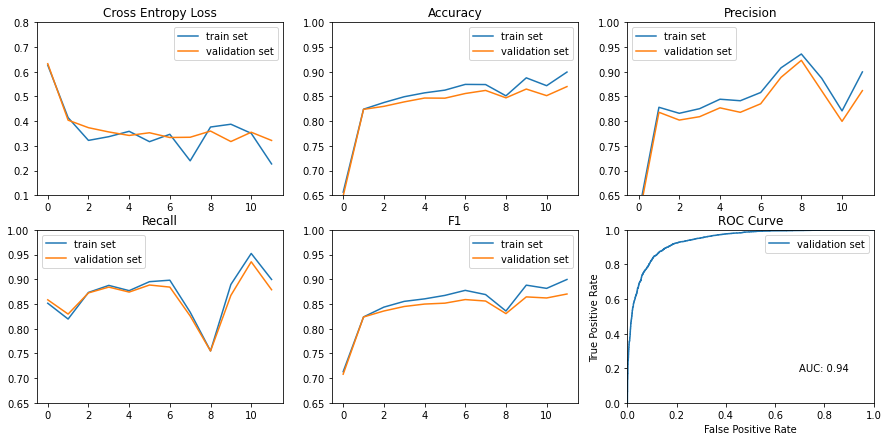

In [ ]:
from sklearn.metrics import classification_report

model_lstm = LSTM(input_size, best_trial_lstm.params['hidden_size'], best_trial_lstm.params['hidden_layers'],
                  num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr = best_trial_lstm.params['learning_rate'], weight_decay = 0.008) 

model_lstm.train()
y_train, train_outputs, y_val, val_outputs = train_model(model_lstm, num_epochs, train_dataloader, validation_dataloader,
                                                         criterion, optimizer, plots = True)

print("Train set:\n", classification_report(y_train, train_outputs))
print("Validation set:\n", classification_report(y_val, val_outputs))

Also save this trained model for later use.

In [ ]:
# torch.save(model_lstm.state_dict(), "model_lstm")
model_lstm = LSTM(input_size, best_trial_lstm.params['hidden_size'], best_trial_lstm.params['hidden_layers'],
                  num_classes).to(device)
model_lstm.load_state_dict(torch.load("model_lstm"))

<All keys matched successfully>

Evaluation of our model using the test set created in the beginning of this notebook. Contrary to the validation set, this test set has not been used anywhere so far, so it contains representative random samples that the model has never seen before.

In [ ]:
all_test_labels = np.array([])
all_test_predictions = np.array([])

model_lstm.eval()

with torch.no_grad():
  for i, ((reviews, review_len), labels) in enumerate(test_dataloader):
    all_test_labels = np.append(all_test_labels, labels.cpu().numpy())
    outputs = model_lstm(reviews, review_len)

    _, predictions = torch.max(outputs, 1)
    all_test_predictions = np.append(all_test_predictions, predictions.cpu().numpy())

print("Test set:\n", classification_report(all_test_labels, all_test_predictions))

Test set:
               precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       922
         1.0       0.88      0.90      0.89       879

    accuracy                           0.89      1801
   macro avg       0.89      0.89      0.89      1801
weighted avg       0.89      0.89      0.89      1801



Hyperparameter tuning for GRU network, using the maximization of F1-score as metric.

We also plot a diagram depicting the objective value of our metric for each trial.

In [ ]:
study = optuna.create_study(direction = "maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective_gru, n_trials = 3)

best_trial_gru = study.best_trial

print("Best hyperparameters for GRU cell:")
for key, value in best_trial_gru.params.items():
  print("{}: {}".format(key, value))

optuna.visualization.plot_optimization_history(study)

[I 2023-01-27 13:13:01,105] A new study created in memory with name: no-name-8a8b91c4-fa07-4e5e-832e-327c22af51f8
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-01-27 13:21:58,557] Trial 0 finished with value: 0.8227546588202326 and parameters: {'learning_rate': 5.791962907945106e-05, 'hidden_size': 256, 'hidden_layers': 2}. Best is trial 0 with value: 0.8227546588202326.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-01-27 13:35:39,109] Trial 1 finished with value: 0.8649173955296404 and parameters: {'

Best hyperparameters for GRU cell:
learning_rate: 0.0007161670980022938
hidden_size: 256
hidden_layers: 3


Train GRU network using the best hyperparameters found before using Optuna and get a classification report for both training and validation sets. Then, by examining whether the scores for these sets are close to each other or not, we can determine if the model overfits or underfits. This can also be seen in the plots following these statistics, where the training and validation curves remain very close to each other with a very small generalization gap, showing that no overfitting or underfitting occurs in our model.

Train set:
               precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     17950
         1.0       0.89      0.91      0.90     18056

    accuracy                           0.90     36006
   macro avg       0.90      0.90      0.90     36006
weighted avg       0.90      0.90      0.90     36006

Validation set:
               precision    recall  f1-score   support

         0.0       0.88      0.85      0.87      3628
         1.0       0.85      0.88      0.87      3573

    accuracy                           0.87      7201
   macro avg       0.87      0.87      0.87      7201
weighted avg       0.87      0.87      0.87      7201



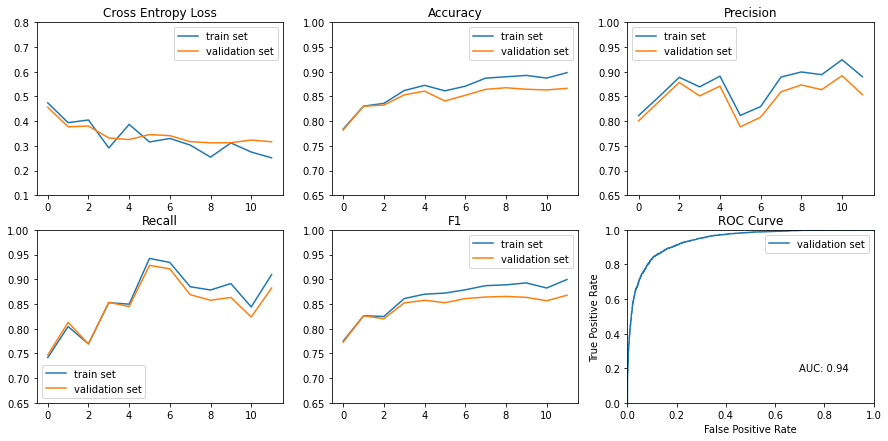

In [ ]:
from sklearn.metrics import classification_report

model_gru = GRU(input_size, best_trial_gru.params['hidden_size'], best_trial_gru.params['hidden_layers'],
                num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr = best_trial_gru.params['learning_rate'], weight_decay = 0.006) 

model_gru.train()
y_train, train_outputs, y_val, val_outputs = train_model(model_gru, num_epochs, train_dataloader, validation_dataloader,
                                                         criterion, optimizer, plots = True)

print("Train set:\n", classification_report(y_train, train_outputs))
print("Validation set:\n", classification_report(y_val, val_outputs))

Also save this trained model for later use.

In [ ]:
# torch.save(model_gru.state_dict(), "model_gru")
model_gru = GRU(input_size, best_trial_gru.params['hidden_size'], best_trial_gru.params['hidden_layers'],
                num_classes).to(device)
model_gru.load_state_dict(torch.load("model_gru"))

<All keys matched successfully>

Evaluation of our model using the test set created in the beginning of this notebook. Contrary to the validation set, this test set has not been used anywhere so far, so it contains representative random samples that the model has never seen before.

In [ ]:
all_test_labels = np.array([])
all_test_predictions = np.array([])

model_gru.eval()

with torch.no_grad():
  for i, ((reviews, review_len), labels) in enumerate(test_dataloader):
    all_test_labels = np.append(all_test_labels, labels.cpu().numpy())
    outputs = model_gru(reviews, review_len)

    _, predictions = torch.max(outputs, 1)
    all_test_predictions = np.append(all_test_predictions, predictions.cpu().numpy())

print("Test set:\n", classification_report(all_test_labels, all_test_predictions))

Test set:
               precision    recall  f1-score   support

         0.0       0.89      0.86      0.88       922
         1.0       0.86      0.89      0.88       879

    accuracy                           0.88      1801
   macro avg       0.88      0.88      0.88      1801
weighted avg       0.88      0.88      0.88      1801



Comparing the evaluation of our previous two models on the test, it seems that the RNN using the GRU cell performs almost equally well to the LSTM one, while also being simpler and thus being trained faster. Let's try to improve it even more, by utilizing the mechanism of attention. To achieve this, we tune it again using Optuna by defining a new objective that calls GRU with `attention = True`, and we also pass `attention=True` when defining our model later for training. Our implementation takes care of the rest.

In [ ]:
def objective_gru_attention(trial):

     params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
              'hidden_size': trial.suggest_categorical("hidden_size", [128, 256]),
              'hidden_layers': trial.suggest_categorical("hidden_layers", [2, 3])
              }
    
     model = GRU(input_size, params['hidden_size'], params['hidden_layers'], num_classes, attention = True).to(device)

     criterion = nn.CrossEntropyLoss()
     optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate'], weight_decay=0.0005)
    
     all_train_labels, all_train_predictions, all_val_labels, all_val_predictions = train_model(model, num_epochs,
                                                    train_dataloader, validation_dataloader, criterion, optimizer)

     return f1_score(all_val_labels, all_val_predictions)

In [ ]:
study = optuna.create_study(direction = "maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective_gru_attention, n_trials = 3, show_progress_bar=True)

best_trial_gru_attention = study.best_trial

print("Best hyperparameters for GRU cell:")
for key, value in best_trial_gru_attention.params.items():
  print("{}: {}".format(key, value))

optuna.visualization.plot_optimization_history(study)

[I 2023-01-27 18:01:17,455] A new study created in memory with name: no-name-4997428f-743c-42d8-a1f2-df9cd5484614
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2023-01-27 18:26:34,390] Trial 0 finished with value: 0.847558260353273 and parameters: {'learning_rate': 0.00042548551292115376, 'hidden_size': 256, 'hidden_layers': 3}. Best is trial 0 with value: 0.847558260353273.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2023-01-27 18:47:08,306] Trial 1 finished with value: 0.8548977103373526 and parameters: {'learning_rate': 4.30899056961226e-05, 'hidden_size': 256, 'hidden_layers': 2}. Best is trial 1 with value: 0.8548977103373526.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



[I 2023-01-27 19:07:41,860] Trial 2 finished with value: 0.8608423061196675 and parameters: {'learning_rate': 4.812317702679991e-05, 'hidden_size': 256, 'hidden_layers': 2}. Best is trial 2 with value: 0.8608423061196675.
Best hyperparameters for GRU cell:
learning_rate: 4.812317702679991e-05
hidden_size: 256
hidden_layers: 2


Train set:
               precision    recall  f1-score   support

         0.0       0.87      0.86      0.87     17950
         1.0       0.86      0.88      0.87     18056

    accuracy                           0.87     36006
   macro avg       0.87      0.87      0.87     36006
weighted avg       0.87      0.87      0.87     36006

Validation set:
               precision    recall  f1-score   support

         0.0       0.87      0.83      0.85      3628
         1.0       0.84      0.88      0.86      3573

    accuracy                           0.85      7201
   macro avg       0.86      0.85      0.85      7201
weighted avg       0.86      0.85      0.85      7201



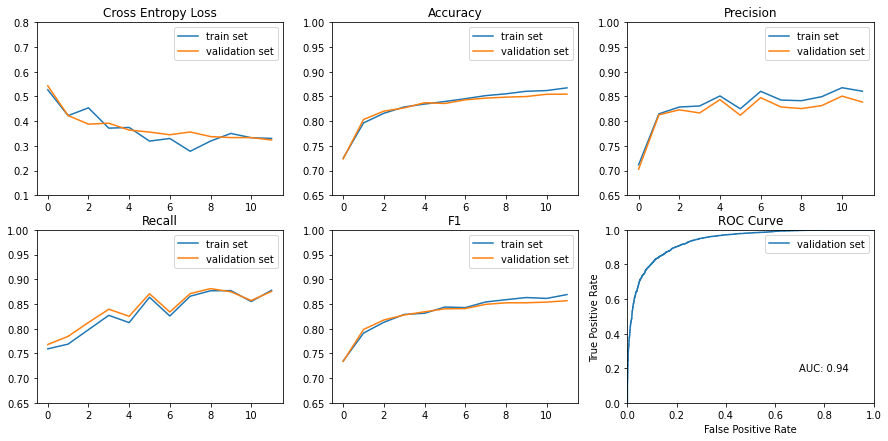

In [ ]:
from sklearn.metrics import classification_report

model_gru_attention = GRU(input_size, best_trial_gru_attention.params['hidden_size'],
                          best_trial_gru_attention.params['hidden_layers'], num_classes, attention = True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru_attention.parameters(), lr = best_trial_gru_attention.params['learning_rate'],
                             weight_decay = 0.0005) 

model_gru_attention.train()
y_train, train_outputs, y_val, val_outputs = train_model(model_gru_attention, num_epochs, train_dataloader,
                                                         validation_dataloader, criterion, optimizer, plots = True)

print("Train set:\n", classification_report(y_train, train_outputs))
print("Validation set:\n", classification_report(y_val, val_outputs))

Also save this trained model for later use.

In [ ]:
# torch.save(model_gru_attention.state_dict(), "model_gru_attention")
model_gru_attention = GRU(input_size, best_trial_gru_attention.params['hidden_size'],
                          best_trial_gru_attention.params['hidden_layers'], num_classes, attention = True).to(device)
model_gru_attention.load_state_dict(torch.load("model_gru_attention"))

<All keys matched successfully>

We also evaluate the new GRU model that uses attention on our test set.

In [ ]:
all_test_labels = np.array([])
all_test_predictions = np.array([])

model_gru_attention.eval()

with torch.no_grad():
  for i, ((reviews, review_len), labels) in enumerate(test_dataloader):
    all_test_labels = np.append(all_test_labels, labels.cpu().numpy())
    outputs = model_gru_attention(reviews, review_len)

    _, predictions = torch.max(outputs, 1)
    all_test_predictions = np.append(all_test_predictions, predictions.cpu().numpy())

print("Test set:\n", classification_report(all_test_labels, all_test_predictions))

Test set:
               precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       922
         1.0       0.86      0.89      0.87       879

    accuracy                           0.87      1801
   macro avg       0.87      0.87      0.87      1801
weighted avg       0.87      0.87      0.87      1801



Section for testing with a new test dataset given by the user. Just insert the path of your test csv file in the `path_to_your_test_set` variable and run the code (while having already run the code written before this message).
After running the following code, a classification report providing precision, recall and F-measure for your test set will be printed on the screen.

In [ ]:
#########################################
############# YOUR TEST SET #############
#########################################

path_to_your_test_set = 'path'

df_test = pd.read_csv(path_to_your_test_set, sep='\t')

df_test = data_preprocessing(df_test)

df_test = df_test[['reviews_edited', 'target']]
x = df_test[['reviews_edited']]
y = np.ravel(df_test[['target']])

my_test_dataset = CustomDataset(x, y)

my_test_dataloader = torch.utils.data.DataLoader(dataset = my_test_dataset, batch_size = batch_size,
                                              shuffle = True, collate_fn = collate)

all_my_test_labels = np.array([])
all_my_test_predictions = np.array([])

model_lstm.eval()

with torch.no_grad():
  for i, ((reviews, review_len), labels) in enumerate(my_test_dataloader):
    all_my_test_labels = np.append(all_my_test_labels, labels.cpu().numpy())
    outputs = model_lstm(reviews, review_len)

    _, predictions = torch.max(outputs, 1)
    all_my_test_predictions = np.append(all_my_test_predictions, predictions.cpu().numpy())

print("My test set:\n", classification_report(all_my_test_labels, all_my_test_predictions))